In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.interfaces.fmriprep import load_confounds
sys.path.append('..')
from utils.data import Subject, load_participant_list

In [5]:
base_dir = '/home/ubuntu/data/learning-habits'
bids_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/fmriprep-23.2.1/'

sub_ids = load_participant_list(base_dir)

In [6]:
#subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]
subject = Subject(base_dir, '01', include_modeling=True, include_imaging=True, bids_dir=bids_dir)

In [14]:
run='learning2'
block = getattr(subject, run)

In [15]:
events_df = block.extend_events_df(columns_event={'first_stim': 'first_stim_presentation'})
events_df.head()

,onset,duration,trial_type,trial,first_stim
0,0.001868,0.820289,first_stim_presentation,1,7.0
1,0.822156,1.000000,second_stim_presentation,1,0.0
2,1.822156,1.504399,non_response_feedback,1,0.0
3,3.326556,6.266152,iti,1,0.0
4,9.592707,0.848439,first_stim_presentation,2,1.0


In [17]:
events_df['trial_type'] = events_df.apply(
    lambda row: f"{row['trial_type']}_{int(row['first_stim'])}" if row['trial_type'] == 'first_stim_presentation' else row['trial_type'],
    axis=1
)
events_df.head()

,onset,duration,trial_type,trial,first_stim
0,0.001868,0.820289,first_stim_presentation_7,1,7.0
1,0.822156,1.000000,second_stim_presentation,1,0.0
2,1.822156,1.504399,non_response_feedback,1,0.0
3,3.326556,6.266152,iti,1,0.0
4,9.592707,0.848439,first_stim_presentation_1,2,1.0


# First level

In [18]:
tr = 2.33384
hrf_model = 'spm'
noise_model = 'ar1'
smoothing_fwhm = 5
high_pass = 0.01
motion_type = 'basic'

In [19]:
img_path = subject.img.get(run)
fmri_img = image.load_img(img_path)

In [22]:
confounds, sample_mask  = subject.load_confounds(run, motion_type=motion_type)
confounds.head(2)

,csf,rot_x,rot_y,rot_z,trans_x,trans_y,trans_z,white_matter,cosine00,cosine01,cosine02,cosine03,cosine04
0,-0.524803,-0.004040,-0.00061,0.000743,-0.023657,-0.011646,0.125823,6.807452,0.070089,0.069413,0.070125,0.070211,0.067971
1,36.415179,-0.004133,-0.00032,0.000860,-0.003029,-0.087371,0.134099,10.848257,0.070086,0.069398,0.070092,0.070152,0.067878


In [26]:
n = fmri_img.shape[-1]
frametimes = np.linspace(tr/2., (n - .5)*tr, n) # from Gilles, checked with nilearn FirstLevelModel

In [27]:
X = make_first_level_design_matrix(frame_times=frametimes,
                                    events=events_df,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    high_pass=high_pass,
                                    add_regs=confounds)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
response.
  warnings.warn(
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: first_stim, trial
  warnings.warn(


<Axes: label='conditions', ylabel='scan number'>

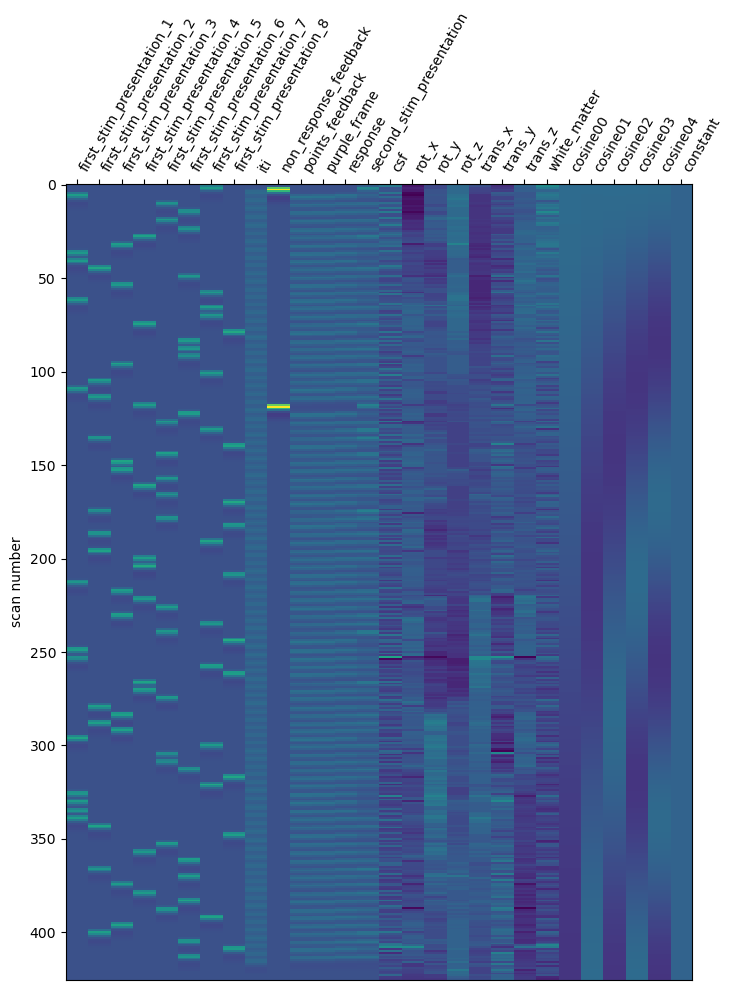

In [28]:
plot_design_matrix(X)

## Optimizing

### Vanilla

In [ ]:
model = FirstLevelModel(smoothing_fwhm=smoothing_fwhm)

In [45]:
model_fit = model.fit(fmri_img, design_matrices=X, sample_masks=sample_mask)

In [58]:
# Extract beta maps for each stimulus
stimuli = ['first_stim_presentation_'+ str(i) for i in range(1,8)]
beta_maps = {}
for stim in stimuli:
    beta_map = model_fit.compute_contrast(stim, output_type='z_score')
    beta_maps[stim[-1]] = beta_map
    print(f"Computed beta map for {stim}")

Computed beta map for first_stim_presentation_1
Computed beta map for first_stim_presentation_2
Computed beta map for first_stim_presentation_3
Computed beta map for first_stim_presentation_4
Computed beta map for first_stim_presentation_5
Computed beta map for first_stim_presentation_6
Computed beta map for first_stim_presentation_7


In [ ]:
from sklearn.metrics import pairwise_distances

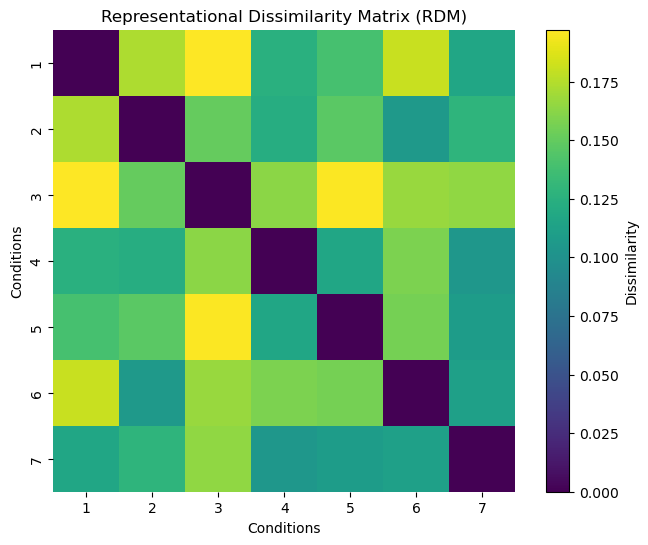

In [64]:
# Extract activation patterns
activation_patterns = np.array([beta_maps[cond].get_fdata().flatten() for cond in beta_maps.keys()])
condition_labels = list(beta_maps.keys())

# Compute the Representational Dissimilarity Matrix (RDM)
rdm = pairwise_distances(activation_patterns, metric='correlation')  # Use 'euclidean' or 'correlation'

# Visualize the RDM
import matplotlib.pyplot as plt
import seaborn as sns


# Plot the heatmap with seaborn
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    rdm, 
    xticklabels=condition_labels, 
    yticklabels=condition_labels, 
    cmap='viridis', 
    square=True,
    cbar=False  # Disable seaborn's default colorbar
)

# Add a single labeled colorbar
colorbar = plt.colorbar(ax.collections[0], label="Dissimilarity")
plt.title("Representational Dissimilarity Matrix (RDM)")
plt.xlabel("Conditions")
plt.ylabel("Conditions")
plt.show()